In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from astropy.cosmology import LambdaCDM
import astropy.units as u
from extinction import fitzpatrick99
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## 1. The catalogue

In [2]:
blcat_orig = pd.read_excel('data/combined_dataset_BLCat.xlsx')  # combined dataset
blcat = blcat_orig.copy()  # for further cleansing and reduction
blcat.drop('Unnamed: 0', axis=1, inplace=True)
blcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_SDSS_i,ext_SDSS_z,ext_PS1_g,ext_PS1_r,ext_PS1_i,ext_PS1_z,ext_PS1_y,FIRST_peak_flux,FIRST_integrated_flux,FIRST_rms_noise
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.049,0.037,0.092,0.066,0.049,0.038,0.031,NaN,NaN,NaN
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.070,0.052,0.132,0.094,0.070,0.055,0.045,NaN,NaN,NaN
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.054,0.040,0.101,0.072,0.053,0.042,0.034,225.01,235.87,0.278


In [3]:
# A cell for reviewing this "wide" dataset by columns

blcat.iloc[:,100:120].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ext_J                  1724 non-null   float64
 1   ext_H                  1724 non-null   float64
 2   ext_K                  1724 non-null   float64
 3   ext_SDSS_u             1724 non-null   float64
 4   ext_SDSS_g             1724 non-null   float64
 5   ext_SDSS_r             1724 non-null   float64
 6   ext_SDSS_i             1724 non-null   float64
 7   ext_SDSS_z             1724 non-null   float64
 8   ext_PS1_g              1724 non-null   float64
 9   ext_PS1_r              1724 non-null   float64
 10  ext_PS1_i              1724 non-null   float64
 11  ext_PS1_z              1724 non-null   float64
 12  ext_PS1_y              1724 non-null   float64
 13  FIRST_peak_flux        659 non-null    float64
 14  FIRST_integrated_flux  659 non-null    float64
 15  FIRS

In [4]:
# Dropping unnecessary columns 
blcat.drop(columns=[
    'err', 'err.1', 'err.2', 'err.3', 'err.4', 'err.5', 'err.6', 
    'u_err','g_err','r_err','i_err','z_err', 
    'gMeanPSFMagErr', 'rMeanPSFMagErr', 'iMeanPSFMagErr', 'zMeanPSFMagErr', 
    'yMeanPSFMagErr',
    'fuv_magerr', 'nuv_magerr', 'fuv_fluxerr', 'nuv_fluxerr', 
    'w1_err','w2_err','w3_err','w4_err',
    'J_err','H_err','K_err', 
    'FIRST_rms_noise',
    'PSTARRS_offset', 'GALEX_offset', 'WISE_offset'],
    inplace=True)

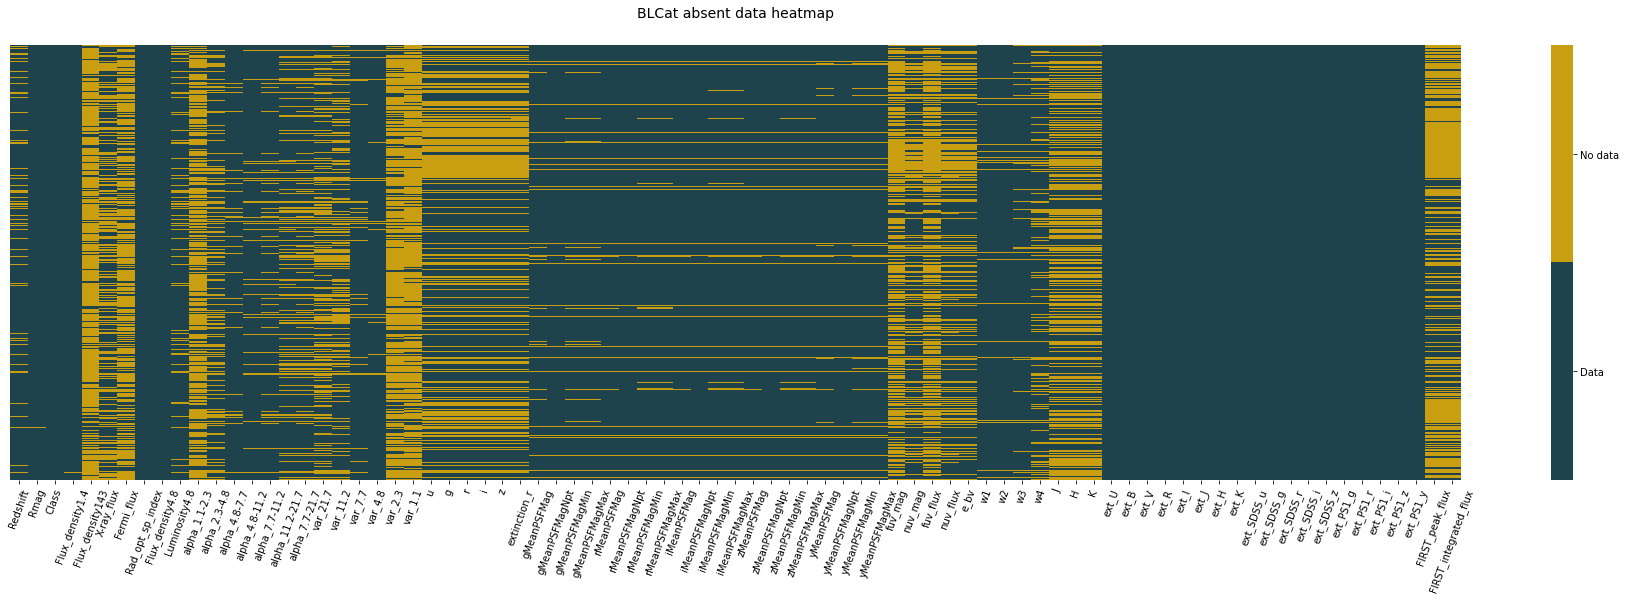

In [5]:
# NaN heatmap

colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    blcat.iloc[:,3:].isnull(), # All columns except name and coords 
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BLCat absent data heatmap', y=1.05, fontsize = 14);

***Effective wavelengths***

**GALEX FUV, NUV:** 1538.6, 2315.7 Angstroms (Morrissey et al. 2007, ApJ, 173, 682)

**SDSS ugriz:** 3557, 4702, 6175, 7491, 8946 Angstroms (https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/)

**PanSTARRS grizy:** 4810, 6170, 7520, 8660, 9620 Angstroms (Tonry et al., 2012, ApJ, 750, 99)

**2MASS JHK:** 1.235, 1.662, 2.159 micrometers (IR) (Cohen et al., 2003, AJ, 126, 1090)

**WISE w1-w4:** 3.3526, 4.6028, 11.5608, 22.0883 micrometers (IR) (Jarett et al., 2011, ApJ, 735, 112)

**FIRST**: 20 cm

In [6]:
GALEX_WL = [1538.6, 2315]
SDSS_WL = [3557, 4702, 6175, 7491, 8946]
PSTARRS_WL = [4810, 6170, 7520, 8660, 9620]
TMASS_WL = [12350, 16620, 21590]
WISE_WL = [33526, 46028, 115608, 220883]

---

**Class designations**

7211 - BZQ (Flat Spectrum Radio Quasars)

7300 - BZB (BL Lac)

7309 - BZG (potential BL Lacs showing host galaxy emission dominance over the continuum)

7900 - BZU (uncertain type)

7390 - BZB (BL Lac candidates) 

## 2. Cosmology

In [7]:
""" 
LambdaCDM cosmology with the Planck Collaboration cosmological parameters:

Hubble constant:                      67.74 km s^(-1) Mpc^(-1)
Matter density parameter:             0.3089 (in units of the critical density)
Dark energy density parameter:        0.6911 (in units of the critical density)
CMB temperature:                      2.725 K
Effective number of neutrino species: 3.15
Neutrino mass:                        0.12 eV
Baryon density parameter:             0.0486 (in units of the critical density)
"""

cosmology_lcdm = LambdaCDM(H0=67.74, Om0=0.3089, Ode0=0.6911, Tcmb0=2.725,
                           Neff=3.15, m_nu=0.12, Ob0=0.0486)

Warnings below are because of the NaN values in redshifts

In [8]:
blcat['universe_age_Gyr'] = blcat['Redshift'].apply(cosmology_lcdm.age)
blcat['universe_age_Gyr'] = blcat['universe_age_Gyr'].apply(lambda x:
    round(float(x / (1 * u.Gyr)), 3))

blcat['comoving_distance_Mpc'] \
    = blcat['Redshift'].apply(cosmology_lcdm.comoving_distance)
blcat['comoving_distance_Mpc'] \
    = blcat['comoving_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))
# Because the program gives zeros for NaN redshidts for some reason:
blcat['comoving_distance_Mpc'] \
    = blcat['comoving_distance_Mpc'].replace(0, np.NaN)

blcat['lookback_distance_Mpc'] \
    = blcat['Redshift'].apply(cosmology_lcdm.lookback_distance)
blcat['lookback_distance_Mpc'] \
    = blcat['lookback_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))
# Because the program gives zeros for NaN redshidts for some reason:
blcat['lookback_distance_Mpc'] \
    = blcat['lookback_distance_Mpc'].replace(0, np.NaN)

blcat['luminosity_distance_Mpc'] \
    = blcat['Redshift'].apply(cosmology_lcdm.luminosity_distance)
blcat['luminosity_distance_Mpc'] \
    = blcat['luminosity_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))

blcat['distance_modulus_mag'] = blcat['Redshift'].apply(cosmology_lcdm.distmod)
blcat['distance_modulus_mag'] = blcat['distance_modulus_mag'].apply(lambda x: 
    float(x / (1 * u.mag)))

/home/dkudr/.local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:996: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._lookback_time_integrand_scalar, z, np.inf)[0]


## 3. Right ascention and declination

In [9]:
# RA, Dec: to sines and cosines

FULL_CIRCLE = 1_296_000  # arcseconds in a full circle

def ra_to_arcsec(x):
    hms = x.split()
    return (int(hms[0])*3600+int(hms[1])*60+float(hms[2])) * 15

def del_to_arcsec(x):
    dms = x.split()
    if dms[0][0] == '-':
        return int(dms[0])*3600 - int(dms[1])*60 - float(dms[2])
    else:
        return int(dms[0])*3600 + int(dms[1])*60 + float(dms[2])


blcat['RA_arcsec'] = blcat['RA (J2000.0)'].apply(ra_to_arcsec)
blcat['Dec_arcsec'] = blcat['Dec (J2000.0)'].apply(del_to_arcsec)

blcat['RA_sin'] = np.sin(2 * np.pi * blcat['RA_arcsec'] / FULL_CIRCLE)
blcat['RA_cos'] = np.cos(2 * np.pi * blcat['RA_arcsec'] / FULL_CIRCLE)

# I take sin(Dec) because it changes from 1 to -1 at Dec=90 to Dec=-90
# and three coordinates is enough to identify a point on a sphere
blcat['Dec_sin'] = np.sin(2 * np.pi * blcat['Dec_arcsec'] / FULL_CIRCLE)

blcat.drop(['RA_arcsec', 'Dec_arcsec', 'RA (J2000.0)', 'Dec (J2000.0)'], 
           inplace=True, axis=1)

blcat.head(3)

,BZCAT5 Source name,Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,Rad_opt_sp_index,Flux_density4.8,...,FIRST_peak_flux,FIRST_integrated_flux,universe_age_Gyr,comoving_distance_Mpc,lookback_distance_Mpc,luminosity_distance_Mpc,distance_modulus_mag,RA_sin,RA_cos,Dec_sin
0,5BZQJ0001-1551,2.044,18.1,7211,348.0,NaN,NaN,NaN,0.661,200,...,NaN,NaN,3.181,5353.362866,3233.870858,16260.664058,46.055691,0.004748,0.999989,-0.273152
1,5BZQJ0001+1914,3.100,21.6,7211,265.0,NaN,NaN,NaN,0.917,140,...,NaN,NaN,2.048,6572.092926,3581.229063,26858.453527,47.145405,0.004990,0.999988,0.329572
2,5BZBJ0001-0746,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,0.553,180,...,225.01,235.87,NaN,NaN,NaN,NaN,NaN,0.005672,0.999984,-0.135267


## 4. Extinction

The extinctions from the SDSS and NED (the latter based on Schlafly et al., 2011, ApJ, 737, 103) are the same:

In [10]:
blcat[['extinction_r', 'ext_SDSS_r']].head()

,extinction_r,ext_SDSS_r
0,NaN,0.066
1,0.09,0.095
2,0.07,0.072
3,0.08,0.078
4,0.08,0.081


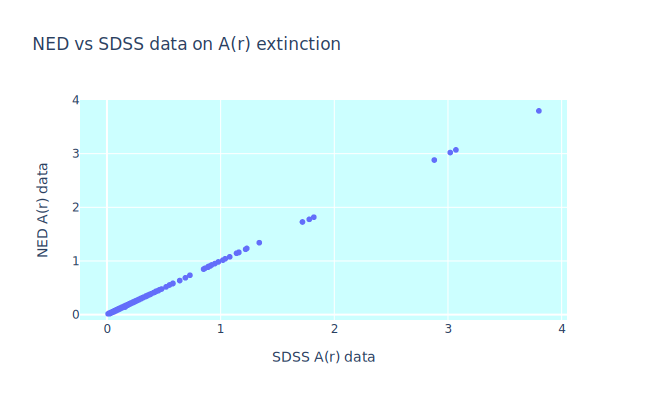

In [11]:
fig = px.scatter(
    blcat, x='extinction_r', y='ext_SDSS_r',
    width=647, height=400,
    range_y=(-0.1, 4),
    title='NED vs SDSS data on A(r) extinction')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.layout.xaxis.title.text = 'SDSS A(r) data'
fig.layout.yaxis.title.text = 'NED A(r) data'
fig.show('svg')

The $E(B-V)$ from the GALEX and NED data are similar, although a little systematic shift is observed. I'll take the NED data (no missed values)

In [12]:
blcat['ebv'] = blcat['ext_B'] - blcat['ext_V']
blcat[['e_bv', 'ebv']].head()

,e_bv,ebv
0,0.028843,0.026
1,NaN,0.036
2,0.031354,0.028
3,0.033941,0.030
4,0.035323,0.032


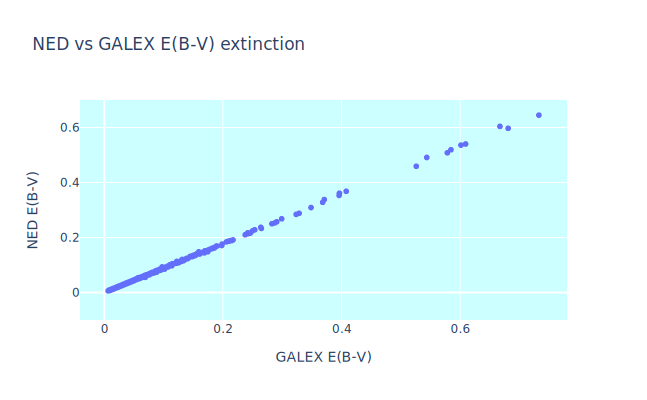

In [13]:
fig = px.scatter(
    blcat, x='e_bv', y='ebv',
    width=647, height=400,
    range_y=(-0.1, 0.7),
    title='NED vs GALEX E(B-V) extinction')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.layout.xaxis.title.text = 'GALEX E(B-V)'
fig.layout.yaxis.title.text = 'NED E(B-V)'
fig.show('svg')

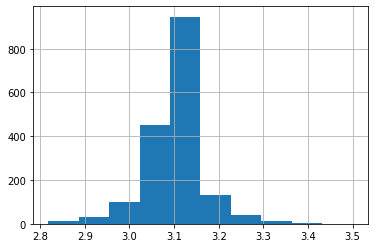

In [14]:
blcat['rv'] = blcat['ext_V'] / blcat['ebv']
blcat['rv'].hist();

The above histogram with the typical $R_V = 3.1$ corresponds to the expected value for the Galaxy

Calculating extinctions for the GALEX fuv, nuv filters from the extinction law (Fitzpatrick, 1999, PASP, 111, 63). Extinction in the WISE w1-w4 filters is about one order of magnitude less than the typical errors

In [15]:
def ext_calc(x):
    extinctions = fitzpatrick99(np.array([1538.6, 2315.7]), 
                                x['ext_V'], x['rv'])
    return pd.Series(extinctions)


blcat[['ext_fuv', 'ext_nuv']] = blcat.apply(ext_calc, axis=1) 

## 5. Optical fluxes

In [16]:
# Percent of missing values in optical magnitudes
blcat[['Rmag', 'fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 
       'zMeanPSFMag', 'yMeanPSFMag', 'u', 'g', 'r', 'i', 'z', 'J', 'H', 'K', 
       'w1', 'w2', 'w3', 'w4']].isnull().mean()

Rmag           0.001160
fuv_mag        0.609629
nuv_mag        0.319606
gMeanPSFMag    0.084107
rMeanPSFMag    0.074246
iMeanPSFMag    0.069026
zMeanPSFMag    0.071346
yMeanPSFMag    0.085267
u              0.414153
g              0.414153
r              0.414153
i              0.414153
z              0.414153
J              0.491299
H              0.491299
K              0.491299
w1             0.042923
w2             0.042343
w3             0.078886
w4             0.223898
dtype: float64

In [17]:
# Dropping BZCAT Rmag - it is not exactly the R magnitude 
# (there are values from other bands according to the authors)
blcat.drop(columns=['Rmag'], inplace=True)

Calculating $\log_{10}(\nu F_\nu)$ in ${\rm erg} / ({\rm cm}^2\,{\rm s})$

In [18]:
# This is an "operative" version, I'm going to wright a special class for the calculations

def mag2flux(
    data, wl, mag, extinction=None, zeromag_flux=None, units='cgs'):
    
    c = 299_792_458     # speed of light (m/s)
    A2m = 1E-10         # Angstroms to meters
    UNITS_SI = 1E-26    # From 1 Jy = 10^{-26} W*m^{-2}*Hz^{-1}
    UNITS_CGS = 1E-23   # From 1 Jy = 10^{-23} erg*s^{-1}*cm^{-2}*Hz^{-1}
    
    if zeromag_flux==None:
        zeromag_flux = 3631 * np.ones(len(mag))
    if extinction==None:
        extinction = np.zeros((data.shape[0], len(mag)))
    else:
        extinction = np.array(data[extinction])
        
    log_nuflux = np.zeros((data.shape[0], len(mag)))
    nu = np.zeros(len(mag))
    col_out = []
    for i, col in enumerate(mag):           
        col_out.append(col + '_log_nuflux')
        nu[i] = c / (wl[i]*A2m)
        if units=='si':
            log_nuflux[:, i] = np.log10(UNITS_SI * zeromag_flux[i] \
                * 10**((data[col]-extinction[:, i])/-2.5) * nu[i])
        if units=='cgs':
            log_nuflux[:,i] = np.log10(UNITS_CGS * zeromag_flux[i] \
                * 10**((data[col]-extinction[:, i])/-2.5) * nu[i])
    return pd.DataFrame(log_nuflux, columns=col_out), list(np.log10(nu))

In [19]:
# GALEX
mag = ['fuv_mag', 'nuv_mag']
ext = ['ext_fuv', 'ext_nuv']
galex_flux_cols = ['log_nuF_fuv', 'log_nuF_nuv']
blcat[galex_flux_cols], galex_lognu = mag2flux(
       data=blcat, wl=GALEX_WL, mag=mag, extinction=ext)
    
# Pan-STARRS 1
mag = ['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
       'zMeanPSFMag', 'yMeanPSFMag']
ext = ['ext_PS1_g', 'ext_PS1_r', 'ext_PS1_i', 'ext_PS1_z', 'ext_PS1_y']
pstarrs_flux_cols = ['log_nuF_g', 'log_nuF_r', 'log_nuF_i', 'log_nuF_z', 'log_nuF_y']
blcat[pstarrs_flux_cols], pstarrs_lognu = mag2flux(
       data=blcat, wl=PSTARRS_WL, mag=mag, extinction=ext)

# SDSS
blcat['u'] = blcat['u']-0.04  # corr .for AB mag deviation
blcat['z'] = blcat['z']+0.02  # corr .for AB mag deviation
mag = ['u', 'g', 'r', 'i', 'z']
ext = ['ext_SDSS_u', 'ext_SDSS_g', 'ext_SDSS_r', 'ext_SDSS_i', 'ext_SDSS_z']
sdss_flux_cols = ['log_nuF_Su', 'log_nuF_Sg', 'log_nuF_Sr', 
             'log_nuF_Si', 'log_nuF_Sz']
blcat[sdss_flux_cols], sdss_lognu = mag2flux(
       data=blcat, wl=SDSS_WL, mag=mag, extinction=ext)

# 2MASS
mag = ['J', 'H', 'K']
ext = ['ext_J', 'ext_H', 'ext_K']
zeromag_flux = [1594, 1024, 666.8]
tmass_flux_cols = ['log_nuF_J', 'log_nuF_H', 'log_nuF_K']
blcat[tmass_flux_cols], tmass_lognu = mag2flux(
    data=blcat, wl=TMASS_WL, mag=mag, 
    extinction=ext, zeromag_flux=zeromag_flux)

# WISE
mag = ['w1', 'w2', 'w3', 'w4']
zeromag_flux = [309.54, 171.787, 31.674, 8.363]
wise_flux_cols = ['log_nuF_w1', 'log_nuF_w2', 'log_nuF_w3', 'log_nuF_w4']
blcat[wise_flux_cols], wise_lognu = mag2flux(
       data=blcat, wl=WISE_WL, mag=mag, zeromag_flux=zeromag_flux)    

Next, I'm playing a bit by drawing the SEDs 

In [20]:
#blcat = blcat[(blcat['Redshift'] > 3.) & (blcat['Redshift'] < 4)].reset_index()

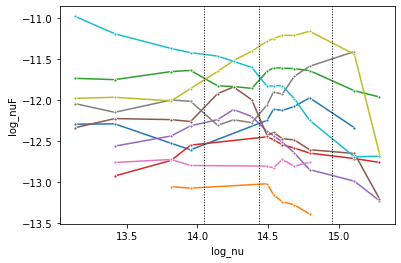

In [21]:
# "Discontinuous" spectra
#start = 50
#j = 0
#for i in range(start, start+10):
#    df = pd.DataFrame({'log_nu': galex_lognu, 'log_nuF': blcat.loc[i, galex_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': pstarrs_lognu, 'log_nuF': blcat.loc[i, pstarrs_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': sdss_lognu, 'log_nuF': blcat.loc[i, sdss_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': tmass_lognu, 'log_nuF': blcat.loc[i, tmass_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': wise_lognu, 'log_nuF': blcat.loc[i, wise_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    j += 1

# All filters
#lognu = galex_lognu + pstarrs_lognu + sdss_lognu + tmass_lognu + wise_lognu
#flux_cols = galex_flux_cols + pstarrs_flux_cols + sdss_flux_cols \
#    + tmass_flux_cols + wise_flux_cols

# Withous SDSS
lognu = galex_lognu + pstarrs_lognu + tmass_lognu + wise_lognu
flux_cols = galex_flux_cols + pstarrs_flux_cols \
    + tmass_flux_cols + wise_flux_cols

#flux_cols = ['fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
#             'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H', 'K', 'w1', 'w2', 'w3', 'w4']
   
start = 0
for i in range(start, start+10):
    df = pd.DataFrame({'log_nu': lognu, 'log_nuF': (blcat.loc[i, flux_cols])})
    #df.sort_values('log_nu', inplace=True)
    sns.lineplot(data=df, x='log_nu', y='log_nuF', marker='.')
plt.axvline(x=((galex_lognu[-1]+pstarrs_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((pstarrs_lognu[-1]+tmass_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((tmass_lognu[-1]+wise_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1);

Calculating $\log_{10}\nu$ ***in the sourse rest*** frame for different filters

In [22]:
coef = 299_792_458 * 1E10 

blcat['fuv_lognu'] = np.log10(coef / GALEX_WL[0] * (1+blcat['Redshift']))
blcat['nuv_lognu'] = np.log10(coef / GALEX_WL[1] * (1+blcat['Redshift']))
blcat['g_lognu'] = np.log10(coef / PSTARRS_WL[0] * (1+blcat['Redshift']))
blcat['r_lognu'] = np.log10(coef / PSTARRS_WL[1] * (1+blcat['Redshift']))
blcat['i_lognu'] = np.log10(coef / PSTARRS_WL[2] * (1+blcat['Redshift']))
blcat['z_lognu'] = np.log10(coef / PSTARRS_WL[3] * (1+blcat['Redshift']))
blcat['y_lognu'] = np.log10(coef / PSTARRS_WL[4] * (1+blcat['Redshift']))
blcat['J_lognu'] = np.log10(coef / TMASS_WL[0] * (1+blcat['Redshift']))
blcat['H_lognu'] = np.log10(coef / TMASS_WL[1] * (1+blcat['Redshift']))
blcat['K_lognu'] = np.log10(coef / TMASS_WL[2] * (1+blcat['Redshift']))
blcat['w1_lognu'] = np.log10(coef / WISE_WL[0] * (1+blcat['Redshift']))
blcat['w2_lognu'] = np.log10(coef / WISE_WL[1] * (1+blcat['Redshift']))
blcat['w3_lognu'] = np.log10(coef / WISE_WL[2] * (1+blcat['Redshift']))
blcat['w4_lognu'] = np.log10(coef / WISE_WL[3] * (1+blcat['Redshift']))

Next figure: the SEDS in the rest frame of the sources. The line colors doesn't correspond with the previous figure! This one is only for demonstration. I'm currently going to work in the observer's frame of reference, having the redshifts to be taken into account by the ML models themselves. 

<Figure size 432x288 with 0 Axes>

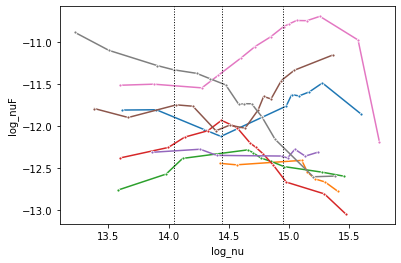

In [23]:
lognu_at_source = [
    'fuv_lognu', 'nuv_lognu', 'g_lognu', 'r_lognu', 'i_lognu','z_lognu', 
    'y_lognu', 'J_lognu', 'H_lognu', 'K_lognu', 'w1_lognu', 'w2_lognu', 
    'w3_lognu', 'w4_lognu'] 
flux_cols = galex_flux_cols + pstarrs_flux_cols \
    + tmass_flux_cols + wise_flux_cols

#flux_cols = ['fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
#             'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H', 'K', 'w1', 'w2', 'w3', 'w4']

temp = pd.DataFrame()
for col in flux_cols:
    temp[col] = blcat[col] + np.log10(1+blcat['Redshift'])  

start = 0
fig = plt.figure()
plt.figure(facecolor='white')
for i in range(start, start+10):
    df = pd.DataFrame(
        {'log_nu': (blcat.loc[i, lognu_at_source]).reset_index(drop=True), 
         'log_nuF': (temp.loc[i, flux_cols]).reset_index(drop=True)})
    #df.sort_values('log_nu', inplace=True)
    ax = sns.lineplot(data=df, x='log_nu', y='log_nuF', marker='.')
plt.axvline(x=((galex_lognu[-1]+pstarrs_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((pstarrs_lognu[-1]+tmass_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((tmass_lognu[-1]+wise_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1);
#ax.set_title('Blazars at 3 < z < 4\n')

In [24]:
# Removing the frequencies re-calculated for the figure

blcat.drop(columns=lognu_at_source, inplace=True)

## 6. Optical magnitudes

In [25]:
# Two optical absolute magnitudes. 
# The i magnitude is for the sake of possible approximation of NaN values in w1
# There is no K correction! For the ML modeling purpose only: 
# possible dependencies to fill in the NaNs.

blcat['i_abs'] = blcat['iMeanPSFMag'] - blcat['ext_PS1_i'] - blcat['distance_modulus_mag']
blcat['w1_abs'] = blcat['w1'] - blcat['distance_modulus_mag']

Let's compare the i and w1 dependencies on distance

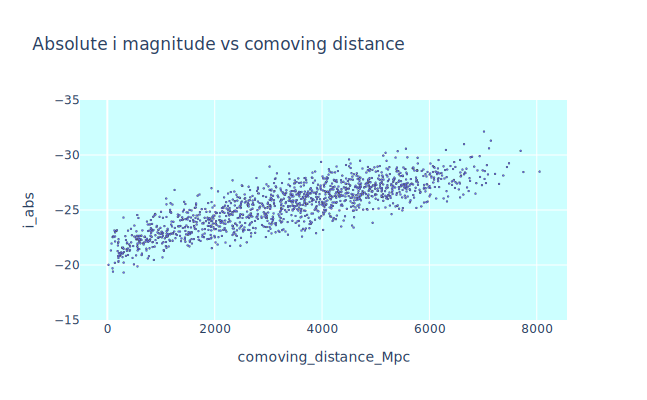

In [26]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='i_abs', #facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='i_abs', 
    width=647, height=400,
    range_y=(-15, -35),
    title='Absolute i magnitude vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_yaxes(autorange='reversed')
fig.update_traces(marker_line_width=0.5, marker={'size':2}) #, marker_line_color='white')
fig.show('svg')

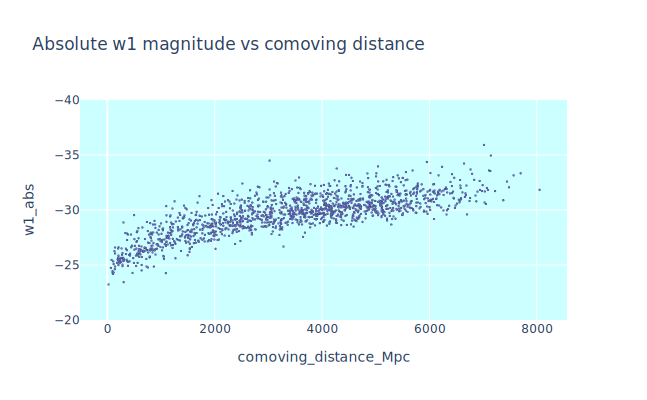

In [27]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='i_abs', #facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='w1_abs', 
    width=647, height=400,
    range_y=(-20, -40),
    title='Absolute w1 magnitude vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_yaxes(autorange='reversed')
fig.update_traces(marker_line_width=0.5, marker={'size':2}) #, marker_line_color='white')
fig.show('svg')

## 7. X-ray flux

$L = 4\pi D^2 F$

The flux $F$ in the BZCAT is given in $10^{-12}~{\rm erg} / ({\rm cm}^2\,{\rm s})$ for the 0.1-2.4 keV band (5-124 Angstroms), $D$ is the luminosity distance. We will give the lumonosity in watts and in the logarithmic scale. There is no K-korrection. At the maximum redshift z = 5.3, the emitting band is ~0.8-20 Angstroms (0.6-15 KeV)

In [28]:
Mpc2cm = 3.086e+24  # Mpc to centimeters
# 1e-7 is for conversion from erg/s to W

blcat['log_X_luminosity_W'] = np.log(4 * np.pi * blcat['X-ray_flux'] * 1E-12
    * (blcat['luminosity_distance_Mpc']*Mpc2cm)**2 * 1e-7)

# Recalculating the flux value according to the optical data
blcat['log_nuF_X'] = np.log10(blcat['X-ray_flux'] * 1E-12) 

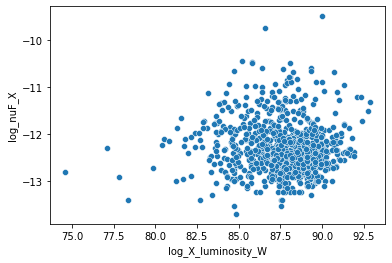

In [29]:
sns.scatterplot(data=blcat, x='log_X_luminosity_W', y='log_nuF_X');

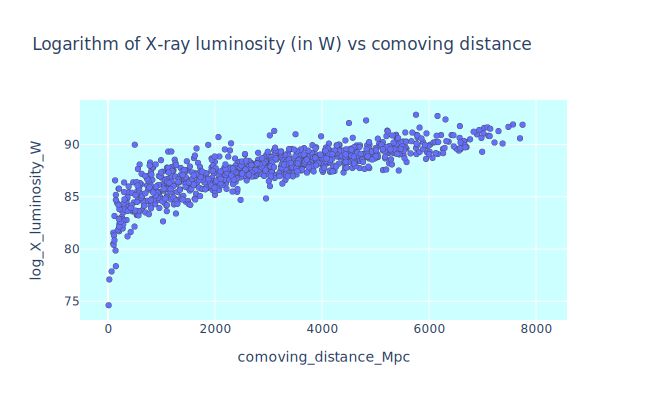

In [30]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_X_luminosity_W', #facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='log_X_luminosity_W',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of X-ray luminosity (in W) vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

In [31]:
blcat.drop(columns='X-ray_flux', inplace=True)

## 8. Gamma ray flux

$L = 4\pi D^2 F$

The gamma ray flux $F$ in the BZCAT is given in ${\rm photons} / ({\rm cm}^2\,{\rm s})$ for the 1-100 GeV band (1.2E-7 - 1.2E-5 Angstroms), $D$ is the luminosity distance. We will give the absolute lumonosity in photons per second and in the logarithmic scale. There is no K-korrection. At z = 5.3, the emitting band is 1.9E-8 - 1.9E-6 Angstroms (6.5-650 GeV)

In [32]:
Mpc2cm = 3.086e+24  # Mpc to centimeters

blcat['log_gamma_luminosity_ph'] = np.log(4 * np.pi * blcat['Fermi_flux'] 
    * (blcat['luminosity_distance_Mpc']*Mpc2cm)**2)

# Recalculating the flux value according to the optical data
coef = 1.60218E-12 * 50E9  # 50 GeV to ergs 
blcat['log_nuF_gamma'] = np.log10(blcat['Fermi_flux'] * coef)

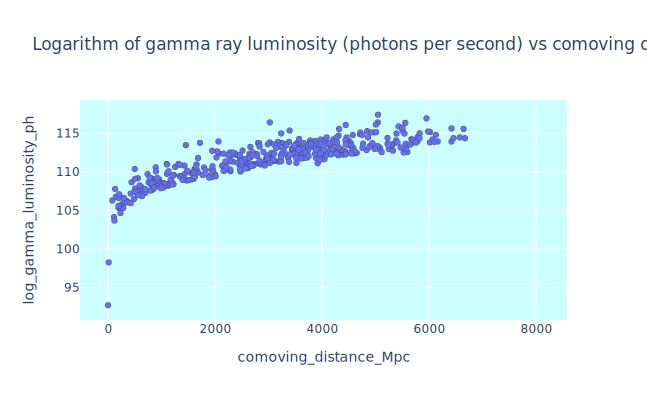

In [33]:
fig = px.scatter(
    blcat, x='comoving_distance_Mpc', y='log_gamma_luminosity_ph',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of gamma ray luminosity (photons per second) vs comoving dist.')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

In [34]:
blcat.drop(columns='Fermi_flux', inplace=True)

## 9. Radio luminosity

First, the luminosities from the BLCat. K-correction is implemented: $L_{4.8} = 4\pi D^2 S_{4.8} (1+z)^{-\alpha-1}$, where $S_{4.8}$ is the flux density at 4.8 GHz, $\alpha$ is the average spectral index

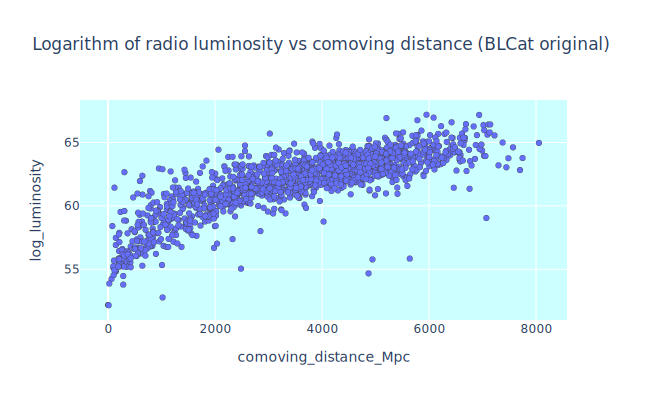

In [35]:
blcat['log_luminosity'] = np.log(blcat['Luminosity4.8'])

fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_luminosity', facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='log_luminosity',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of radio luminosity vs comoving distance (BLCat original)')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

blcat.drop('log_luminosity', axis=1, inplace=True)

Recalculating luminosities from the dataset and our cosmology

In [36]:
# There is one zero value in the 'Flux_density4.8' column: replacing with NaN
blcat['Flux_density4.8'] = blcat['Flux_density4.8'].replace(0, np.NaN)

In [37]:
Mpc2m = 3.086e+22
UNITS = 1e-29  # From flux density in mJy

blcat['alpha_temp'] = blcat.apply(lambda x: x['alpha_4.8-11.2'] 
    if pd.notnull(x['alpha_4.8-11.2']) else x['alpha_4.8-7.7'], axis=1)

blcat['log_radio_luminosity'] = np.log(4 * np.pi \
    * (blcat['luminosity_distance_Mpc']*Mpc2m)**2 \
    * blcat['Flux_density4.8'] * UNITS \
    * (1+blcat['Redshift'])**(-blcat['alpha_temp']-1))
    
display(blcat[['alpha_4.8-11.2', 'alpha_temp', 'Luminosity4.8', 
               'log_radio_luminosity']].isnull().mean())
blcat.drop(['alpha_temp'], inplace=True, axis=1)

alpha_4.8-11.2          0.078886
alpha_temp              0.016821
Luminosity4.8           0.158353
log_radio_luminosity    0.141531
dtype: float64

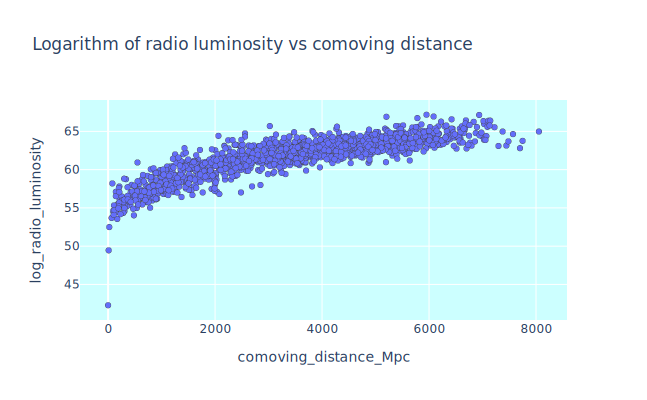

In [38]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_radio_luminosity', facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='log_radio_luminosity',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of radio luminosity vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

In [39]:
# FIRST luminosity (W/Hz). No K-corrections

Mpc2m = 3.086e+22
UNITS = 1e-29  # From flux in mJy

blcat['FIRST_luminosity'] = np.log(4 * np.pi \
    * (blcat['luminosity_distance_Mpc']*Mpc2m)**2 \
    * blcat['FIRST_integrated_flux'] * UNITS)

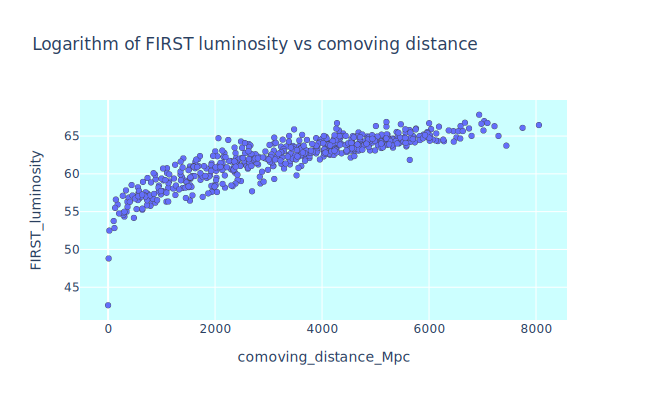

In [40]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_radio_luminosity', facet_col='Class', 
    blcat, x='comoving_distance_Mpc', y='FIRST_luminosity',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of FIRST luminosity vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

Two luminosities correspond with each other, although there is some descrepancy at log L>60 (statistically for higher redshifts). 

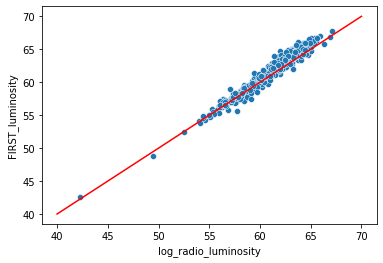

In [41]:
sns.scatterplot(data=blcat, x='log_radio_luminosity', y='FIRST_luminosity')
plt.plot([40, 70], [40, 70], color='red')
plt.show()

In [42]:
# Recalculating the flux values according to the optical data

coef = 10E-26  # mJy to erg/(cm s Hz)
blcat['log_nuF_1.4'] = np.log10(blcat['Flux_density1.4'] * coef * 1.4E9)
blcat['log_nuF_143'] = np.log10(blcat['Flux_density143'] * coef * 143E9)
blcat['log_nuF_4.8'] = np.log10(blcat['Flux_density4.8'] * coef * 4.75E9)
#blcat['log_nuF_FIRST'] = np.log10(blcat['FIRST_integrated_flux'] * coef * 1.4E9)

In [43]:
blcat.drop(columns=
    ['Flux_density143', 'Flux_density1.4', 'Flux_density4.8', 
     'Luminosity4.8', 'FIRST_peak_flux', 'FIRST_integrated_flux'],
    inplace=True)

We don't need the FIRST data actually - BZCAT may include the same data in fluxed at 1.4 GHz

In [44]:
blcat.drop(columns='FIRST_luminosity', inplace=True)

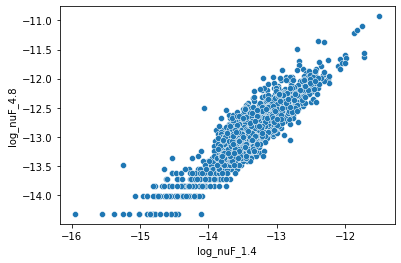

In [45]:
ax = sns.scatterplot(data=blcat, x='log_nuF_1.4', y='log_nuF_4.8')
#ax.set_ylim([1000, 1100])

In [46]:
flux_cols = ['log_nuF_gamma'] + ['log_nuF_X'] + galex_flux_cols \
    + pstarrs_flux_cols + sdss_flux_cols + tmass_flux_cols + wise_flux_cols \
    + ['log_nuF_143'] + ['log_nuF_4.8'] + ['log_nuF_1.4'] 
    
#blcat[blcat['log_nuF_gamma'].notna()][flux_cols].head()
blcat[flux_cols].head()

,log_nuF_gamma,log_nuF_X,log_nuF_fuv,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,log_nuF_Su,...,log_nuF_J,log_nuF_H,log_nuF_K,log_nuF_w1,log_nuF_w2,log_nuF_w3,log_nuF_w4,log_nuF_143,log_nuF_4.8,log_nuF_1.4
0,NaN,NaN,NaN,-12.336429,-11.972098,-12.077398,-12.125891,-12.110271,-12.246688,NaN,...,NaN,NaN,NaN,-12.605844,-12.526411,-12.289864,-12.293380,NaN,-13.022276,-13.312293
1,NaN,NaN,NaN,NaN,-13.387978,-13.275518,-13.238611,-13.154431,-13.019848,-14.146369,...,NaN,NaN,NaN,-13.072645,-13.055211,NaN,NaN,NaN,-13.177178,-13.430626
2,-10.397349,-12.455932,-11.961797,-11.886007,-11.640778,-11.617278,-11.608891,-11.606671,-11.649368,-12.016101,...,-11.856758,-11.83551,-11.825836,-11.638644,-11.652011,-11.750664,-11.734979,NaN,-13.068034,-13.535809
3,NaN,NaN,-12.758931,-12.712343,-12.645858,-12.584398,-12.543171,-12.483111,-12.447248,-12.712853,...,NaN,NaN,NaN,-12.548644,-12.734811,-12.924264,NaN,NaN,-13.624336,-13.808549
4,NaN,NaN,-13.226092,-12.987616,-12.847498,-12.644438,-12.509331,-12.432551,-12.382208,-12.937337,...,-12.199958,-12.11511,-12.238236,-12.313444,-12.436811,-12.561064,NaN,NaN,-13.369064,-13.603452


## 10. Colors

In [47]:
# Percent of missing values
blcat[['fuv_mag', 'nuv_mag', 'u', 'g', 'r', 'i', 'z', 'gMeanPSFMag', 
       'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H',
       'K', 'w1', 'w2', 'w3', 'w4']].isnull().mean()

fuv_mag        0.609629
nuv_mag        0.319606
u              0.414153
g              0.414153
r              0.414153
i              0.414153
z              0.414153
gMeanPSFMag    0.084107
rMeanPSFMag    0.074246
iMeanPSFMag    0.069026
zMeanPSFMag    0.071346
yMeanPSFMag    0.085267
J              0.491299
H              0.491299
K              0.491299
w1             0.042923
w2             0.042343
w3             0.078886
w4             0.223898
dtype: float64

The colors to calculate: fuv-nuv, nuv-SDSS u, SDSS: (u-g, g-r, r-i, i-z), nuv-PanSTARRS g, PanSTARRS: (g-r, r-i, i-z, z-y), PanSTARRS y - J, J-H, H-K,  K-w1, PanSTARRS y - w1, w1-w2, w2-w3, w3-w4.

Most of the colors are just for further possible approximation of NaN data. Because of many missing values, the GALEX, SDSS, and 2MASS data are to be excluded from the "main" problem solution.

In [48]:
# Calculating the "main" colors
blcat['g-r'] = (blcat['gMeanPSFMag']-blcat['ext_PS1_g']) \
    - (blcat['rMeanPSFMag']-blcat['ext_PS1_r'])  # g - PanSTARRS r
blcat['r-i'] = (blcat['rMeanPSFMag']-blcat['ext_PS1_r']) \
    - (blcat['iMeanPSFMag']-blcat['ext_PS1_i'])  # r-i
blcat['i-z'] =  (blcat['iMeanPSFMag']-blcat['ext_PS1_i']) \
    - (blcat['zMeanPSFMag']-blcat['ext_PS1_z'])  # i-z
blcat['z-y'] = (blcat['zMeanPSFMag']-blcat['ext_PS1_z']) \
    - (blcat['yMeanPSFMag']-blcat['ext_PS1_y'])  # z-y
blcat['y-w1'] = (blcat['yMeanPSFMag']-blcat['ext_PS1_y']) - blcat['w1']
blcat['w1-w2'] = blcat['w1'] - blcat['w2']  # WISE w1-w2
blcat['w2-w3'] = blcat['w2'] - blcat['w3']  # w2-w3
blcat['w3-w4'] = blcat['w3'] - blcat['w4']  # w4-w4

# "Auxiliary" colors 
blcat['fuv-nuv'] = (blcat['fuv_mag']-blcat['ext_fuv']) \
    - (blcat['nuv_mag']-blcat['ext_nuv'])
blcat['nuv-Su'] = (blcat['nuv_mag']-blcat['ext_nuv']) \
    - (blcat['u']-blcat['ext_SDSS_u']) # GALEX nuv - SDSS u
blcat['Su-Sg'] = (blcat['u']-blcat['ext_SDSS_u']) \
    - (blcat['g']-blcat['ext_SDSS_g']) # SDSS u-g
blcat['Sg-Sr'] = (blcat['g']-blcat['ext_SDSS_g']) \
    - (blcat['r']-blcat['ext_SDSS_r'])  
blcat['Sr-Si'] = (blcat['r']-blcat['ext_SDSS_r']) \
    - (blcat['i']-blcat['ext_SDSS_i']) 
blcat['Si-Sz'] = (blcat['i']-blcat['ext_SDSS_i']) \
    - (blcat['z']-blcat['ext_SDSS_z']) 
blcat['nuv-g'] = (blcat['nuv_mag']-blcat['ext_nuv']) \
    - (blcat['gMeanPSFMag']-blcat['ext_PS1_g'])
blcat['y-J'] = (blcat['yMeanPSFMag']-blcat['ext_PS1_y']) \
    - (blcat['J']-blcat['ext_J'])
blcat['J-H'] = (blcat['J']-blcat['ext_J']) \
    - (blcat['H']-blcat['ext_H'])
blcat['H-K'] = (blcat['H']-blcat['ext_H']) \
    - (blcat['K']-blcat['ext_K'])
blcat['K-w1'] = (blcat['K']-blcat['ext_K']) - blcat['w1']

MAIN_COLORS = ['g-r', 'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4']
AUX_COLORS = ['fuv-nuv', 'nuv-Su', 'Su-Sg', 'Sg-Sr', 'Sr-Si', 'Si-Sz', 'nuv-g', 
              'y-J', 'J-H', 'H-K', 'K-w1']

In [49]:
# Dropping converted columns

blcat.drop(columns=[
    'extinction_r', 'e_bv', 'ebv', 'rv', 'ext_fuv', 'ext_nuv', 'ext_U', 'ext_B',
    'ext_V', 'ext_R', 'ext_I', 'ext_J', 'ext_H', 'ext_K', 'ext_SDSS_u',
    'ext_SDSS_g', 'ext_SDSS_r', 'ext_SDSS_i', 'ext_SDSS_z', 'ext_PS1_g',
    'ext_PS1_r', 'ext_PS1_i', 'ext_PS1_z', 'ext_PS1_y', 'fuv_mag', 'nuv_mag',
    'fuv_flux', 'nuv_flux', 
    'u', 'g', 'r', 'i', 'z', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 
    'zMeanPSFMag', 'yMeanPSFMag', 'w1',  'w2','w3', 'w4', 'J', 'H', 'K'
    ], 
    inplace=True)

## 11. Variability

In [50]:
# MinMax differences

blcat['g_var'] = blcat['gMeanPSFMagMax'] - blcat['gMeanPSFMagMin']
blcat['r_var'] = blcat['rMeanPSFMagMax'] - blcat['rMeanPSFMagMin']
blcat['i_var'] = blcat['iMeanPSFMagMax'] - blcat['iMeanPSFMagMin']
blcat['z_var'] = blcat['zMeanPSFMagMax'] - blcat['zMeanPSFMagMin']
blcat['y_var'] = blcat['yMeanPSFMagMax'] - blcat['yMeanPSFMagMin']

In [51]:
# Correlation between optical variabilities
blcat[['g_var', 'r_var', 'i_var', 'z_var', 'y_var']].corr(method='spearman')

,g_var,r_var,i_var,z_var,y_var
g_var,1.000000,0.445381,0.416893,0.376499,0.324267
r_var,0.445381,1.000000,0.486606,0.433337,0.321384
i_var,0.416893,0.486606,1.000000,0.469241,0.375464
z_var,0.376499,0.433337,0.469241,1.000000,0.448987
y_var,0.324267,0.321384,0.375464,0.448987,1.000000


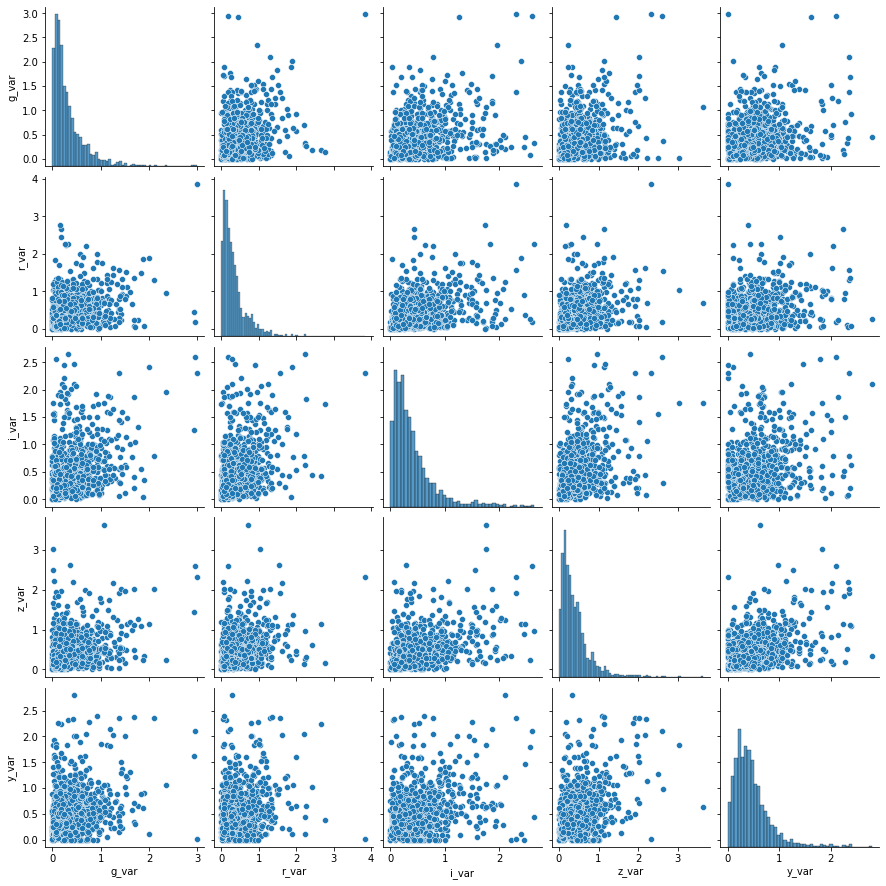

In [52]:
sns.pairplot(blcat[['g_var', 'r_var', 'i_var', 'z_var', 'y_var']]);

In [53]:
# Correlation between radio variabilities
blcat[['var_21.7', 'var_11.2', 'var_7.7', 'var_4.8']].corr()

,var_21.7,var_11.2,var_7.7,var_4.8
var_21.7,1.000000,0.429989,0.268493,0.362109
var_11.2,0.429989,1.000000,0.295668,0.513485
var_7.7,0.268493,0.295668,1.000000,0.322926
var_4.8,0.362109,0.513485,0.322926,1.000000


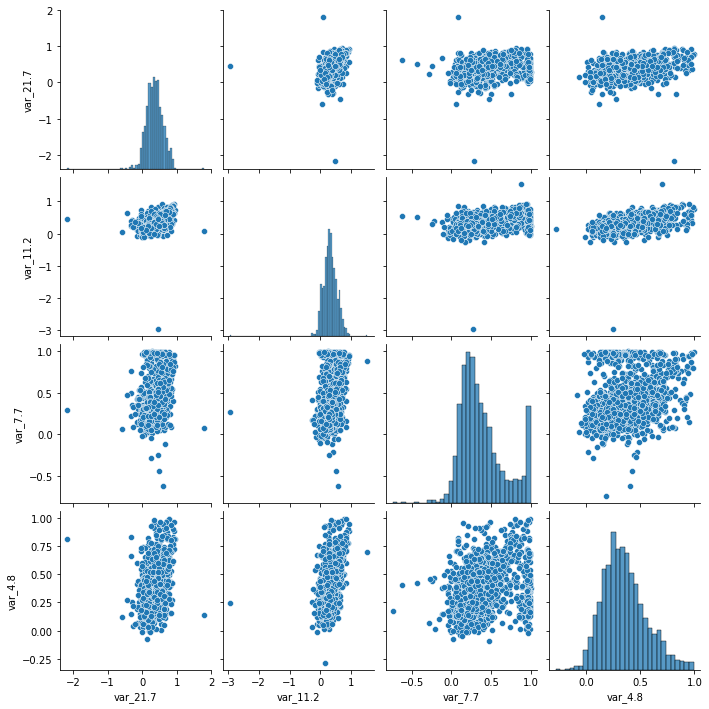

In [54]:
sns.pairplot(blcat[['var_21.7', 'var_11.2', 'var_7.7', 'var_4.8']]);

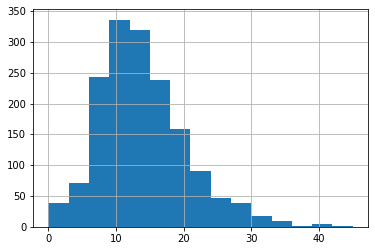

In [55]:
# PanSTARRS typical number of observations
blcat['iMeanPSFMagNpt'].hist(bins=15);

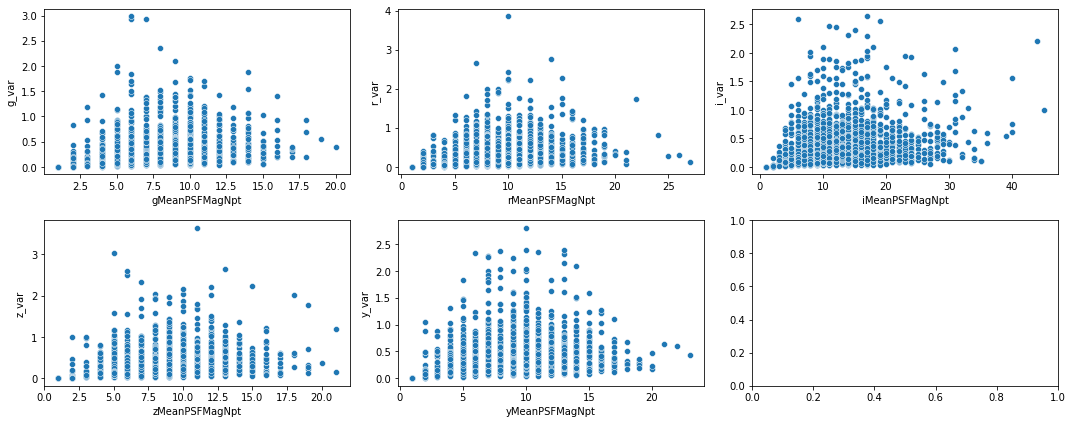

In [56]:
# Variability vs number of measuremets

fig, ax = plt.subplots(2, 3, figsize=(15,6))
sns.scatterplot(x=blcat['gMeanPSFMagNpt'], y=blcat['g_var'], ax=ax[0,0])
sns.scatterplot(x=blcat['rMeanPSFMagNpt'], y=blcat['r_var'], ax=ax[0,1])
sns.scatterplot(x=blcat['iMeanPSFMagNpt'], y=blcat['i_var'], ax=ax[0,2])
sns.scatterplot(x=blcat['zMeanPSFMagNpt'], y=blcat['z_var'], ax=ax[1,0])
sns.scatterplot(x=blcat['yMeanPSFMagNpt'], y=blcat['y_var'], ax=ax[1,1])
fig.tight_layout()

A quasi-normal distribution is seen. The right wing with a greater number of observations shows a variability descent most probably because of a fewer number of objects, given that higher variabilities are not often. I'll take all measurements of ${\rm var} = m_{\rm max} - m_{\rm min}$ where the measurements number > 1. 

In [57]:
def var2nan(x):
    if x['gMeanPSFMagNpt']==0 or x['gMeanPSFMagNpt']==1:
        x['g_var'] = np.NaN
    if x['rMeanPSFMagNpt']==0 or x['rMeanPSFMagNpt']==1:
        x['r_var'] = np.NaN
    if x['iMeanPSFMagNpt']==0 or x['iMeanPSFMagNpt']==1:
        x['i_var'] = np.NaN
    if x['zMeanPSFMagNpt']==0 or x['zMeanPSFMagNpt']==1:
        x['z_var'] = np.NaN
    if x['yMeanPSFMagNpt']==0 or x['yMeanPSFMagNpt']==1:
        x['y_var'] = np.NaN
    return x
        

blcat = blcat.apply(var2nan, axis=1)        

In [58]:
# Dropping converted columns

blcat.drop(columns=[
    'gMeanPSFMagNpt', 'gMeanPSFMagMin', 'gMeanPSFMagMax',
    'rMeanPSFMagNpt', 'rMeanPSFMagMin', 'rMeanPSFMagMax',
    'iMeanPSFMagNpt', 'iMeanPSFMagMin', 'iMeanPSFMagMax',
    'zMeanPSFMagNpt', 'zMeanPSFMagMin', 'zMeanPSFMagMax',
    'yMeanPSFMagNpt', 'yMeanPSFMagMin', 'yMeanPSFMagMax'],
    inplace=True
)

## 12. Classes

**Class designations**

7211 - BZQ (Flat Spectrum Radio Quasars)

7300 - BZB (BL Lac)

7309 - BZG (potential BL Lacs showing host galaxy emission dominance over the continuum)

7900 - BZU (uncertain type)

7390 - BZB (BL Lac candidates) 

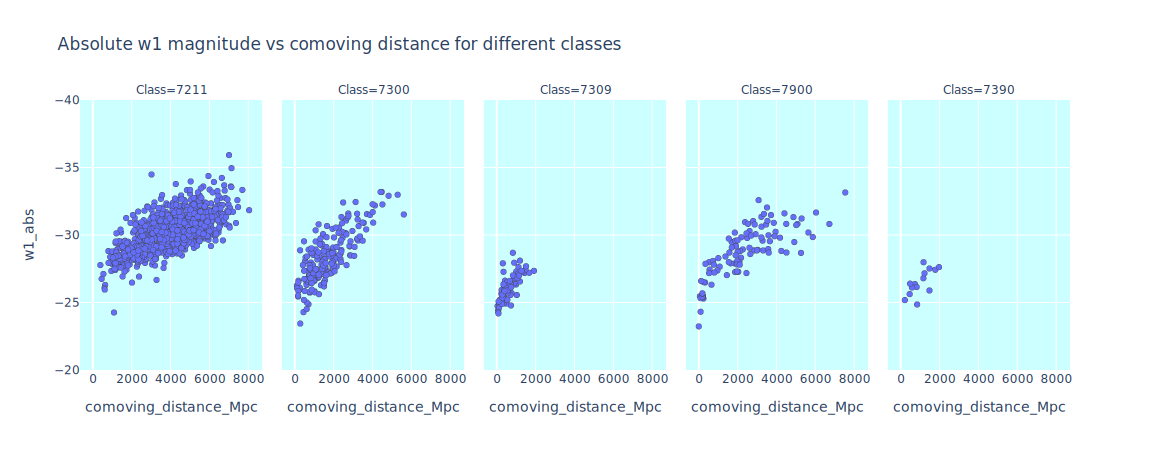

In [59]:
fig = px.scatter(blcat, x='comoving_distance_Mpc', y='w1_abs', facet_col='Class', 
                 range_y=(-20,-40), width=1150, height=450,
                 title='Absolute w1 magnitude vs comoving distance for different classes')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

I'll combine BZU and BL Lac candidates.

In [60]:
blcat['Class'].replace({
    7211: 'BZQ', 7300: 'BLLac', 7309: 'BZG', 7900: 'BZU', 7390: 'BZU'}, 
    inplace=True)

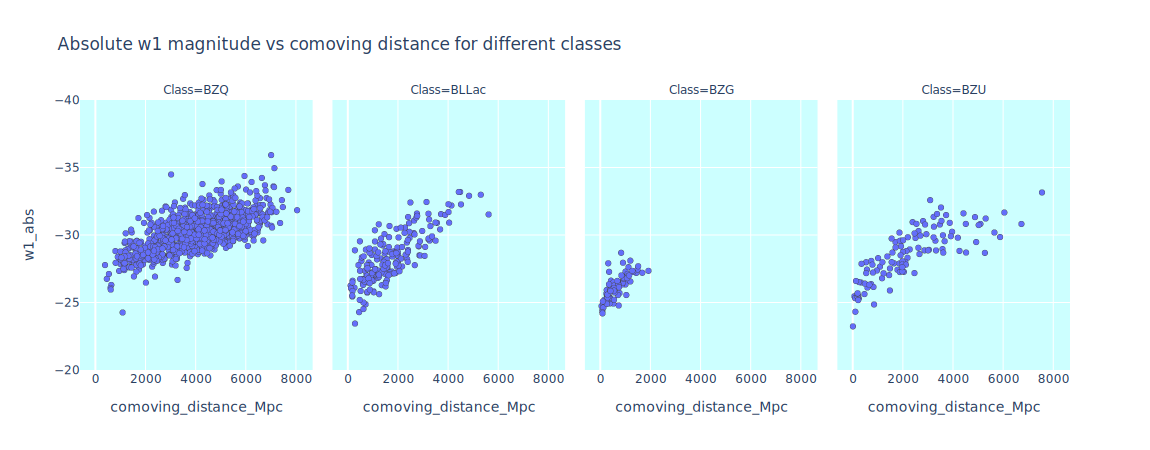

In [61]:
fig = px.scatter(blcat, x='comoving_distance_Mpc', y='w1_abs', facet_col='Class', 
                 range_y=(-20,-40),
                 width=1150, height=450,
                 title='Absolute w1 magnitude vs comoving distance for different classes')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

Different dependencies for different classes? Or different distributions along the distance?

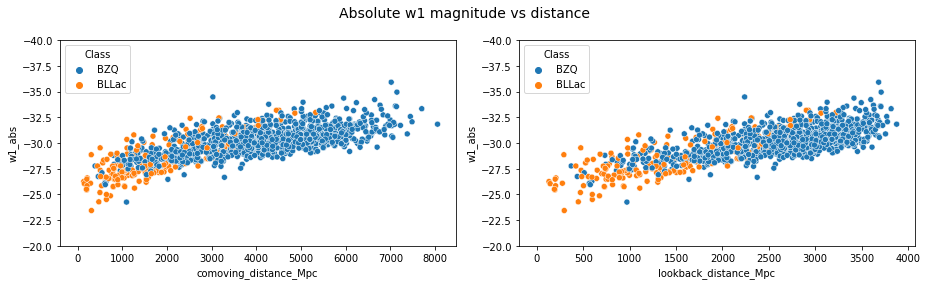

In [62]:
mask = (blcat['Class']=='BZQ') | (blcat['Class']=='BLLac')

fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.scatterplot(data=blcat[mask], x='comoving_distance_Mpc', y='w1_abs', 
                hue='Class', ax=ax[0])
sns.scatterplot(data=blcat[mask], x='lookback_distance_Mpc', y='w1_abs', 
                hue='Class', ax=ax[1])
ax[0].set_ylim(-20, -40)
ax[1].set_ylim(-20, -40)
fig.suptitle('Absolute w1 magnitude vs distance', fontsize=14)
fig.tight_layout()

In [63]:
# One-hot encoding for the classes
dummies = pd.get_dummies(blcat['Class'])
blcat = pd.concat([blcat, dummies], axis=1)

In [64]:
blcat.to_csv('./data/all_features.csv')